In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential,model_from_json
from keras.layers import Dense, Dropout, LeakyReLU

Using TensorFlow backend.


In [116]:
df = pd.read_csv('InvoicePayment-evaluation.csv')

In [117]:
df.columns

Index(['PwC_RowID', 'BusinessTransaction', 'CompanyCode', 'CompanyName',
       'DocumentNo', 'DocumentType', 'DocumentTypeDesc', 'EntryDate',
       'EntryTime', 'InvoiceAmount', 'InvoiceDate', 'InvoiceDesc',
       'InvoiceItemDesc', 'LocalCurrency', 'PaymentDate', 'PaymentDocumentNo',
       'Period', 'PO_FLag', 'PO_PurchasingDocumentNumber', 'PostingDate',
       'PurchasingDocumentDate', 'ReferenceDocumentNo', 'ReportingAmount',
       'TransactionCode', 'TransactionCodeDesc', 'UserName', 'VendorName',
       'VendorCountry', 'Year', 'PaymentDueDate'],
      dtype='object')

In [118]:
df['PaymentDueDate'] = pd.to_datetime(df['PaymentDueDate'])
df['PaymentDate'] = pd.to_datetime(df['PaymentDate'])


In [119]:
df['EntryDate'] = pd.to_datetime(df['EntryDate'])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [120]:
df['PaymentDueDateDifferenceWithEntryDate'] = df['PaymentDueDate'] - df['EntryDate']
df['PaymentDueDateDifferenceWithInvoiceDate'] = df['PaymentDueDate'] - df['InvoiceDate']

In [121]:
df['PaymentDueDateDifferenceWithEntryDate'] = df['PaymentDueDateDifferenceWithEntryDate'].dt.days
df['PaymentDueDateDifferenceWithInvoiceDate'] = df['PaymentDueDateDifferenceWithInvoiceDate'].dt.days

In [122]:
df.loc[(df['PaymentDueDateDifferenceWithEntryDate'] < 0) & (df['PaymentDueDateDifferenceWithEntryDate'] > -30), \
       'PaymentDueDate'] = df['PaymentDueDate'] + pd.DateOffset(months=1)
df.loc[(df['PaymentDueDateDifferenceWithEntryDate'] < -30) & (df['PaymentDueDateDifferenceWithEntryDate'] > -60), \
       'PaymentDueDate'] = df['PaymentDueDate'] + pd.DateOffset(months=2)
df.loc[df['PaymentDueDateDifferenceWithEntryDate'] < -300, \
       'PaymentDueDate'] = df['PaymentDueDate'] + pd.DateOffset(years=1)


In [123]:
df = df[df['PaymentDueDateDifferenceWithEntryDate'] > 0]

In [124]:
df['PaymentDateDifferenceWithPaymentDueDate'] = df['PaymentDate'] - df['PaymentDueDate']

In [125]:
df['PaymentDateDifferenceWithPaymentDueDate'] = df['PaymentDateDifferenceWithPaymentDueDate'].dt.days

In [126]:
working_columns = ['BusinessTransaction', 'CompanyCode','DocumentType','InvoiceAmount', 'VendorName', 'UserName', 
                   'VendorCountry', 'PaymentDateDifferenceWithPaymentDueDate', 'PaymentDueDateDifferenceWithEntryDate', 'TransactionCode']

In [127]:
df = df[working_columns]

In [128]:
def one_hot_encode_and_merge(df_to_encode, column_name):
    df_to_encode[column_name] = df_to_encode[column_name].str.lower()
    one_hot_encode = pd.get_dummies(df_to_encode[column_name])
    df_to_encode = df_to_encode.merge(one_hot_encode, left_index=True, right_index=True)
    df_to_encode = df_to_encode.drop(columns=[column_name])
    return df_to_encode

In [129]:
columns_to_one_hot_encode = ['BusinessTransaction', 'VendorName', 'CompanyCode','DocumentType', 'TransactionCode', 'UserName', 'VendorCountry']

In [130]:
for col in columns_to_one_hot_encode:
    df = one_hot_encode_and_merge(df, col)

In [131]:
df = df[df['InvoiceAmount'] > 0]
df = df[df['InvoiceAmount'] < 10000]

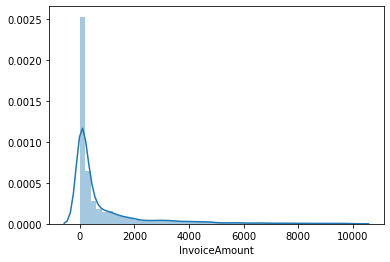

In [132]:
sns.distplot(df['InvoiceAmount'])

In [133]:
X = df.drop(columns=['PaymentDateDifferenceWithPaymentDueDate'])
Y = df['PaymentDateDifferenceWithPaymentDueDate']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [47]:
from keras.layers import Dense, Dropout, LeakyReLU
from keras.regularizers import l1
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor

In [48]:
def build_model():
    adam = Adam(lr=0.0001)
    model = Sequential()
    model.add(Dense(8096,input_dim=X_train.shape[1],activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(4096,input_dim=X_train.shape[1],activation='relu'))
    model.add(Dense(1024,input_dim=X_train.shape[1],activation='relu'))
    model.add(Dense(50,input_dim=X_train.shape[1]))
    model.add(Dense(1))
    model.compile(optimizer= adam, loss='mse',metrics=['mae','mse'])
    return model

In [49]:
model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8096)              14378496  
_________________________________________________________________
batch_normalization_1 (Batch (None, 8096)              32384     
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              33165312  
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_4 (Dense)              (None, 50)                51250     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 51,822,821
Trainable params: 51,806,629
Non-trainable pa

In [51]:
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=20, batch_size=256)

Train on 168001 samples, validate on 42001 samples
Epoch 1/20
168001/168001 [==============================] - 68s 406us/step - loss: 30.6401 - mean_absolute_error: 2.7158 - mean_squared_error: 30.6401 - val_loss: 78.6448 - val_mean_absolute_error: 5.1707 - val_mean_squared_error: 78.6448
Epoch 2/20
168001/168001 [==============================] - 68s 406us/step - loss: 23.9604 - mean_absolute_error: 2.1512 - mean_squared_error: 23.9604 - val_loss: 41.6394 - val_mean_absolute_error: 3.4886 - val_mean_squared_error: 41.6394
Epoch 3/20
168001/168001 [==============================] - 68s 406us/step - loss: 23.0067 - mean_absolute_error: 1.9757 - mean_squared_error: 23.0067 - val_loss: 27.9034 - val_mean_absolute_error: 2.4966 - val_mean_squared_error: 27.9034
Epoch 4/20
168001/168001 [==============================] - 68s 406us/step - loss: 21.5043 - mean_absolute_error: 1.9259 - mean_squared_error: 21.5043 - val_loss: 18.1963 - val_mean_absolute_error: 1.8120 - val_mean_squared_error: 1

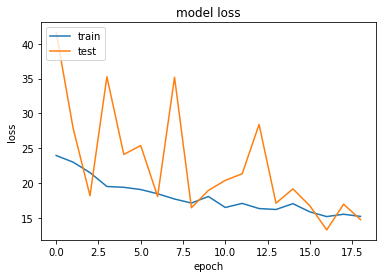

In [52]:
x_axis = history.history['loss'][1:]
y_axis = history.history['val_loss'][1:]
# plt.plot(x_axis)
# plt.plot(y_axis)
# plt.title('model error')
# plt.ylabel('error')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.plot(x_axis)
plt.plot(y_axis)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

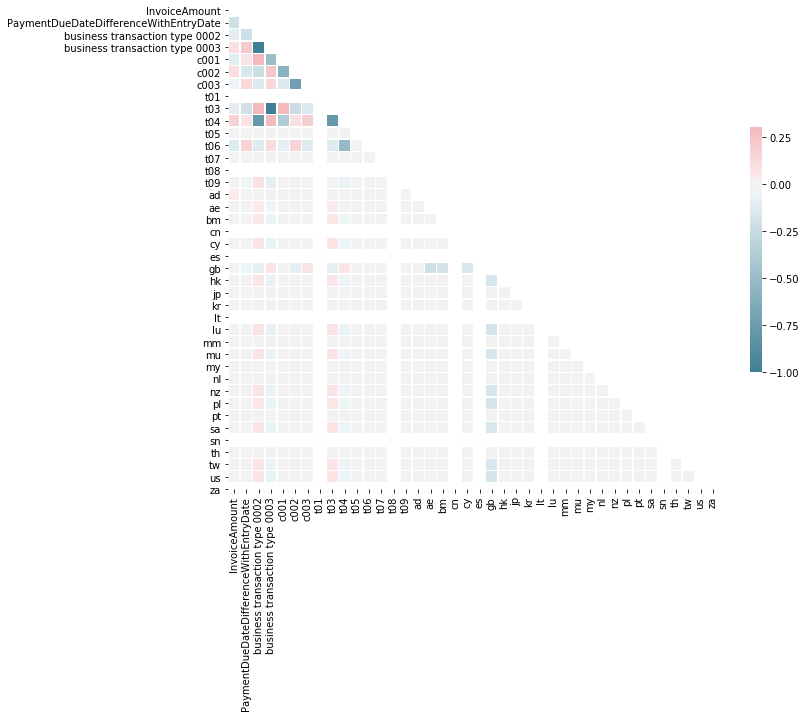

In [200]:
corr = X.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [164]:
predicted = model.predict(X_test)
final = []
for predict in predicted:
    final.append(round(predict[0]))

In [ ]:
np.mean(abs(final - y_test))